In [1]:
library(sf)
library(tmap)
library(tmaptools)
library(dplyr)
library(lubridate)
library(ggplot2)
library(gstat)
library(sp)

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE

Breaking News: tmap 3.x is retiring. Please test v4, e.g. with
remotes::install_github('r-tmap/tmap')


载入程序包：‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



载入程序包：‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
# Read the census shapefile
census <- st_read(dsn="./data/nyc2020_census/nyct2020.shp", layer="nyct2020")

# Load the population csv data
population <- read.csv("./data/nyc_censusdata_2020.csv")
population$BCT2020 <- as.character(population$BCT2020)

# Join population data to census data
census_joined <- census %>%
  left_join(population, by= c("BoroCT2020"="BCT2020"))

# Load Citibike data
citibike_1 <- read.csv("./data/2019-citibike-tripdata/10_October/201910-citibike-tripdata_1.csv")
citibike_2 <- read.csv("./data/2019-citibike-tripdata/10_October/201910-citibike-tripdata_2.csv")
citibike_3 <- read.csv("./data/2019-citibike-tripdata/10_October/201910-citibike-tripdata_3.csv")
citibike_oct <- bind_rows(citibike_1, citibike_2, citibike_3)

Reading layer `nyct2020' from data source 
  `/Users/jiazhuangfeng/Documents/project/spatial_analysis/assignment/data/nyc2020_census/nyct2020.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 2325 features and 14 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 913175.1 ymin: 120128.4 xmax: 1067383 ymax: 272844.3
Projected CRS: NAD83 / New York Long Island (ftUS)


In [3]:
head(citibike_oct)

,tripduration,starttime,stoptime,start.station.id,start.station.name,start.station.latitude,start.station.longitude,end.station.id,end.station.name,end.station.latitude,end.station.longitude,bikeid,usertype,birth.year,gender
,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<int>,<chr>,<int>,<int>
1,527,2019-10-01 00:00:05.6180,2019-10-01 00:08:52.9430,3746,6 Ave & Broome St,40.72431,-74.00473,223,W 13 St & 7 Ave,40.73782,-73.99995,41750,Subscriber,1993,1
2,174,2019-10-01 00:00:15.8750,2019-10-01 00:03:10.1680,3301,Columbus Ave & W 95 St,40.79196,-73.96809,3283,W 89 St & Columbus Ave,40.78822,-73.97042,18264,Subscriber,1992,1
3,759,2019-10-01 00:00:19.8240,2019-10-01 00:12:59.7070,161,LaGuardia Pl & W 3 St,40.72917,-73.99810,174,E 25 St & 1 Ave,40.73818,-73.97739,25525,Subscriber,1995,1
4,615,2019-10-01 00:00:21.0680,2019-10-01 00:10:36.6790,254,W 11 St & 6 Ave,40.73532,-73.99800,477,W 41 St & 8 Ave,40.75641,-73.99003,30186,Subscriber,1992,1
5,761,2019-10-01 00:00:26.3800,2019-10-01 00:13:08.3130,161,LaGuardia Pl & W 3 St,40.72917,-73.99810,174,E 25 St & 1 Ave,40.73818,-73.97739,25597,Subscriber,1992,1
6,750,2019-10-01 00:00:37.9060,2019-10-01 00:13:08.4130,161,LaGuardia Pl & W 3 St,40.72917,-73.99810,174,E 25 St & 1 Ave,40.73818,-73.97739,21757,Subscriber,1995,1


In [4]:
library(dplyr)
library(lubridate)

# 添加时间和用户特征
citibike_oct <- citibike_oct %>%
  mutate(
    # 转换时间为日期时间格式
    starttime = as.POSIXct(starttime, format = "%Y-%m-%d %H:%M:%S"),
    stoptime = as.POSIXct(stoptime, format = "%Y-%m-%d %H:%M:%S"),
    
    # 提取日期和小时信息
    ride_date = as.Date(starttime),  # 提取日期
    ride_hour = hour(starttime),    # 提取小时

    # 工作日/周末分类（使用数字星期）
    # 1 = Sunday, 7 = Saturday
    is_weekend = if_else(wday(ride_date) %in% c(1, 7), 1, 0),  # 是否为周末

    # 高峰/非高峰分类（假设高峰时间为早上 7-9 点和下午 5-7 点）
    is_peak = if_else(ride_hour %in% c(7, 8, 9, 17, 18, 19), 1, 0)
  )

In [5]:
# 计算起始站点的统计信息
start_station_oct <- citibike_oct %>%
  group_by(start.station.id, start.station.latitude, start.station.longitude) %>%
  summarise(
    ride_start_count = n(),  # 总骑行开始次数
    weekday_start_count = sum(is_weekend == 0, na.rm = TRUE),  # 工作日骑行开始次数
    weekend_start_count = sum(is_weekend == 1, na.rm = TRUE),  # 周末骑行开始次数
    peak_start_count = sum(is_peak == 1, na.rm = TRUE),  # 高峰时段骑行开始次数
    off_peak_start_count = sum(is_peak == 0, na.rm = TRUE),  # 非高峰时段骑行开始次数
    weekday_peak_start_count = sum(is_weekend == 0 & is_peak == 1, na.rm = TRUE),  # 工作日高峰骑行开始次数
    weekday_offpeak_start_count = sum(is_weekend == 0 & is_peak == 0, na.rm = TRUE),  # 工作日非高峰骑行开始次数
    weekend_peak_start_count = sum(is_weekend == 1 & is_peak == 1, na.rm = TRUE),  # 周末高峰骑行开始次数
    weekend_offpeak_start_count = sum(is_weekend == 1 & is_peak == 0, na.rm = TRUE),  # 周末非高峰骑行开始次数
    usertype_subscriber_start = sum(usertype == "Subscriber", na.rm = TRUE),  # 订阅用户数量
    usertype_customer_start = sum(usertype == "Customer", na.rm = TRUE),  # 临时用户数量
    gender_male_start = sum(gender == 1, na.rm = TRUE),  # 男性用户数量
    gender_female_start = sum(gender == 2, na.rm = TRUE),  # 女性用户数量
    gender_unknown_start = sum(gender == 0, na.rm = TRUE)  # 未知性别用户数量
  ) %>%
  rename(
    station_id = start.station.id,
    station_latitude = start.station.latitude,
    station_longitude = start.station.longitude
  )

# 计算终点站点的统计信息
end_station_oct <- citibike_oct %>%
  group_by(end.station.id, end.station.latitude, end.station.longitude) %>%
  summarise(
    ride_end_count = n(),  # 总骑行结束次数
    weekday_end_count = sum(is_weekend == 0, na.rm = TRUE),  # 工作日骑行结束次数
    weekend_end_count = sum(is_weekend == 1, na.rm = TRUE),  # 周末骑行结束次数
    peak_end_count = sum(is_peak == 1, na.rm = TRUE),  # 高峰时段骑行结束次数
    off_peak_end_count = sum(is_peak == 0, na.rm = TRUE),  # 非高峰时段骑行结束次数
    weekday_peak_end_count = sum(is_weekend == 0 & is_peak == 1, na.rm = TRUE),  # 工作日高峰骑行结束次数
    weekday_offpeak_end_count = sum(is_weekend == 0 & is_peak == 0, na.rm = TRUE),  # 工作日非高峰骑行结束次数
    weekend_peak_end_count = sum(is_weekend == 1 & is_peak == 1, na.rm = TRUE),  # 周末高峰骑行结束次数
    weekend_offpeak_end_count = sum(is_weekend == 1 & is_peak == 0, na.rm = TRUE),  # 周末非高峰骑行结束次数
    usertype_subscriber_end = sum(usertype == "Subscriber", na.rm = TRUE),  # 订阅用户数量
    usertype_customer_end = sum(usertype == "Customer", na.rm = TRUE),  # 临时用户数量
    gender_male_end = sum(gender == 1, na.rm = TRUE),  # 男性用户数量
    gender_female_end = sum(gender == 2, na.rm = TRUE),  # 女性用户数量
    gender_unknown_end = sum(gender == 0, na.rm = TRUE)  # 未知性别用户数量
  ) %>%
  rename(
    station_id = end.station.id,
    station_latitude = end.station.latitude,
    station_longitude = end.station.longitude
  )

# 合并起始站点和终点站点的统计信息
station_oct <- full_join(start_station_oct, end_station_oct,
                         by = c("station_id", "station_latitude", "station_longitude")) %>%
  # 处理 NA 值
  mutate(
    ride_start_count = ifelse(is.na(ride_start_count), 0, ride_start_count),
    ride_end_count = ifelse(is.na(ride_end_count), 0, ride_end_count),
    ride_activity = ride_start_count + ride_end_count,  # 总骑行活动量

    # 工作日/周末骑行统计
    weekday_count = ifelse(is.na(weekday_start_count), 0, weekday_start_count) +
                    ifelse(is.na(weekday_end_count), 0, weekday_end_count),
    weekend_count = ifelse(is.na(weekend_start_count), 0, weekend_start_count) +
                    ifelse(is.na(weekend_end_count), 0, weekend_end_count),

    # 高峰/非高峰骑行统计
    peak_count = ifelse(is.na(peak_start_count), 0, peak_start_count) +
                 ifelse(is.na(peak_end_count), 0, peak_end_count),
    off_peak_count = ifelse(is.na(off_peak_start_count), 0, off_peak_start_count) +
                     ifelse(is.na(off_peak_end_count), 0, off_peak_end_count),

    # 高峰/非高峰细分统计
    weekday_peak_count = ifelse(is.na(weekday_peak_start_count), 0, weekday_peak_start_count) +
                         ifelse(is.na(weekday_peak_end_count), 0, weekday_peak_end_count),
    weekday_offpeak_count = ifelse(is.na(weekday_offpeak_start_count), 0, weekday_offpeak_start_count) +
                            ifelse(is.na(weekday_offpeak_end_count), 0, weekday_offpeak_end_count),
    weekend_peak_count = ifelse(is.na(weekend_peak_start_count), 0, weekend_peak_start_count) +
                         ifelse(is.na(weekend_peak_end_count), 0, weekend_peak_end_count),
    weekend_offpeak_count = ifelse(is.na(weekend_offpeak_start_count), 0, weekend_offpeak_start_count) +
                            ifelse(is.na(weekend_offpeak_end_count), 0, weekend_offpeak_end_count),

    # 用户类型统计
    usertype_subscriber = ifelse(is.na(usertype_subscriber_start), 0, usertype_subscriber_start) +
                          ifelse(is.na(usertype_subscriber_end), 0, usertype_subscriber_end),
    usertype_customer = ifelse(is.na(usertype_customer_start), 0, usertype_customer_start) +
                        ifelse(is.na(usertype_customer_end), 0, usertype_customer_end),

    # 性别统计
    gender_male = ifelse(is.na(gender_male_start), 0, gender_male_start) +
                  ifelse(is.na(gender_male_end), 0, gender_male_end),
    gender_female = ifelse(is.na(gender_female_start), 0, gender_female_start) +
                    ifelse(is.na(gender_female_end), 0, gender_female_end),
    gender_unknown = ifelse(is.na(gender_unknown_start), 0, gender_unknown_start) +
                     ifelse(is.na(gender_unknown_end), 0, gender_unknown_end)
  ) %>%
  # 计算比例
  mutate(
    weekday_ratio = weekday_count / ride_activity,
    weekend_ratio = weekend_count / ride_activity,
    peak_ratio = peak_count / ride_activity,
    off_peak_ratio = off_peak_count / ride_activity,
    weekday_peak_ratio = weekday_peak_count / ride_activity,
    weekday_offpeak_ratio = weekday_offpeak_count / ride_activity,
    weekend_peak_ratio = weekend_peak_count / ride_activity,
    weekend_offpeak_ratio = weekend_offpeak_count / ride_activity
  )

# 查看结果
print(station_oct)


`summarise()` has grouped output by 'start.station.id',
'start.station.latitude'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'end.station.id',
'end.station.latitude'. You can override using the `.groups` argument.


# A tibble: 848 × 53
# Groups:   station_id, station_latitude [848]
   station_id station_latitude station_longitude ride_start_count
        <int>            <dbl>             <dbl>            <dbl>
 1         72             40.8             -74.0             3518
 2         79             40.7             -74.0             2703
 3         82             40.7             -74.0             1460
 4         83             40.7             -74.0             2016
 5        116             40.7             -74.0             7721
 6        119             40.7             -74.0              605
 7        120             40.7             -74.0             1083
 8        127             40.7             -74.0             6563
 9        128             40.7             -74.0             7155
10        143             40.7             -74.0             2400
# ℹ 838 more rows
# ℹ 49 more variables: weekday_start_count <int>, weekend_start_count <int>,
#   peak_start_count <int>, off_peak_start_co

In [6]:
# Convert cleaned July dataset into sf object
station_oct_sf <- station_oct %>%
  st_as_sf(coords = c("station_longitude", "station_latitude"), crs=4326, remove=FALSE)

In [7]:
# Convert Census polygon crs4269 to crs4329
census_joined <- st_transform(census_joined, crs=st_crs(station_oct_sf))

In [8]:
library(dplyr)
library(lubridate)
station_oct_nyc <- station_oct_sf%>%
  # Left join to remove stations outside NYC (do not have census tract)
  st_join(census_joined, join= st_within, left=FALSE)


In [9]:
head(station_oct_nyc[, c("Pop1", "PopU18", "Pop65pl")])

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



Pop1,PopU18,Pop65pl,geometry
<chr>,<chr>,<chr>,<POINT [°]>
"5,504",623,676,POINT (-73.99393 40.76727)
"6,458","1,419",687,POINT (-74.00667 40.71912)
"4,630",818,"1,283",POINT (-74.00017 40.71117)
"2,402",310,233,POINT (-73.97632 40.68383)
"3,853",435,553,POINT (-74.0015 40.74178)
"3,149",697,521,POINT (-73.97803 40.69609)


In [10]:
library(dplyr)

# 指定需要转换的列
columns_to_convert <- c("Pop1", "PopU5", "Pop5t9", "Pop10t14", "Pop15t19", 
                        "Pop20t24", "Pop25t29", "Pop30t34", "Pop35t39", 
                        "PopU18", "Pop65pl", "GQClgHsg", "Fam", "HUnits")

# 去掉逗号并转换为数值
station_oct_nyc <- station_oct_nyc %>%
  mutate(across(all_of(columns_to_convert), ~ as.numeric(gsub(",", "", .))))


In [11]:
head(station_oct_nyc[, c("Pop1", "PopU18", "Pop65pl")])

Pop1,PopU18,Pop65pl,geometry
<dbl>,<dbl>,<dbl>,<POINT [°]>
5504,623,676,POINT (-73.99393 40.76727)
6458,1419,687,POINT (-74.00667 40.71912)
4630,818,1283,POINT (-74.00017 40.71117)
2402,310,233,POINT (-73.97632 40.68383)
3853,435,553,POINT (-74.0015 40.74178)
3149,697,521,POINT (-73.97803 40.69609)


In [12]:
colnames(station_oct_nyc)

[1] "station_id"                  "station_latitude"           
  [3] "station_longitude"           "ride_start_count"           
  [5] "weekday_start_count"         "weekend_start_count"        
  [7] "peak_start_count"            "off_peak_start_count"       
  [9] "weekday_peak_start_count"    "weekday_offpeak_start_count"
 [11] "weekend_peak_start_count"    "weekend_offpeak_start_count"
 [13] "usertype_subscriber_start"   "usertype_customer_start"    
 [15] "gender_male_start"           "gender_female_start"        
 [17] "gender_unknown_start"        "ride_end_count"             
 [19] "weekday_end_count"           "weekend_end_count"          
 [21] "peak_end_count"              "off_peak_end_count"         
 [23] "weekday_peak_end_count"      "weekday_offpeak_end_count"  
 [25] "weekend_peak_end_count"      "weekend_offpeak_end_count"  
 [27] "usertype_subscriber_end"     "usertype_customer_end"      
 [29] "gender_male_end"             "gender_female_end"          
 [31] "gender_unknown_end"          "ride_activity"              
 [33] "weekday_count"               "weekend_count"              
 [35] "peak_count"                  "off_peak_count"             
 [37] "weekday_peak_count"          "weekday_offpeak_count"      
 [39] "weekend_peak_count"          "weekend_offpeak_count"      
 [41] "usertype_subscriber"         "usertype_customer"          
 [43] "gender_male"                 "gender_female"              
 [45] "gender_unknown"              "weekday_ratio"              
 [47] "weekend_ratio"               "peak_ratio"                 
 [49] "off_peak_ratio"              "weekday_peak_ratio"         
 [51] "weekday_offpeak_ratio"       "weekend_peak_ratio"         
 [53] "weekend_offpeak_ratio"       "geometry"                   
 [55] "CTLabel"                     "BoroCode"                   
 [57] "BoroName"                    "CT2020"                     
 [59] "BoroCT2020"                  "CDEligibil"                 
 [61] "NTAName"                     "NTA2020"                    
 [63] "CDTA2020"                    "CDTANAME"                   
 [65] "GEOID"                       "PUMA"                       
 [67] "Shape_Leng"                  "Shape_Area"                 
 [69] "Year"                        "GeoType"                    
 [71] "Borough"                     "GeoID"                      
 [73] "Pop1"                        "Male.P"                     
 [75] "FemP"                        "PopU5"                      
 [77] "Pop5t9"                      "Pop10t14"                   
 [79] "Pop15t19"                    "Pop20t24"                   
 [81] "Pop25t29"                    "Pop30t34"                   
 [83] "Pop35t39"                    "Pop40t44"                   
 [85] "Pop45t49"                    "Pop50t54"                   
 [87] "Pop55t59"                    "Pop60t64"                   
 [89] "Pop65t69"                    "Pop70t74"                   
 [91] "Pop75t79"                    "Pop80t84"                   
 [93] "Pop85pl"                     "MdAge"                      
 [95] "PopU18"                      "Pop65pl"                    
 [97] "GQClgHsg"                    "Fam"                        
 [99] "HUnits"                      "OcHU_1P"                    
[101] "AvgHHSz"

In [13]:
head(station_oct_nyc[, c("Pop1", "PopU18", "Pop65pl")])

Pop1,PopU18,Pop65pl,geometry
<dbl>,<dbl>,<dbl>,<POINT [°]>
5504,623,676,POINT (-73.99393 40.76727)
6458,1419,687,POINT (-74.00667 40.71912)
4630,818,1283,POINT (-74.00017 40.71117)
2402,310,233,POINT (-73.97632 40.68383)
3853,435,553,POINT (-74.0015 40.74178)
3149,697,521,POINT (-73.97803 40.69609)


In [14]:
# 按 BoroCT2020 分组并聚合数据
agg_citibike_oct <- station_oct_nyc %>%
  group_by(BoroCT2020) %>%
  summarise(
    # 因变量
    total_ride_activity = sum(ride_activity, na.rm = TRUE),  # 总骑行活动量
    weekday_rides = sum(weekday_count, na.rm = TRUE),       # 工作日骑行总量
    weekend_rides = sum(weekend_count, na.rm = TRUE),
    peak_rides = sum(peak_count, na.rm = TRUE),             # 高峰骑行总量
    weekday_peak_rides = sum(weekday_peak_count, na.rm = TRUE),  # 工作日高峰骑行总量
    weekday_offpeak_rides = sum(weekday_offpeak_count, na.rm = TRUE),  # 工作日非高峰骑行总量
    weekend_peak_rides = sum(weekend_peak_count, na.rm = TRUE),  # 周末高峰骑行总量
    weekend_offpeak_rides = sum(weekend_offpeak_count, na.rm = TRUE),  # 周末非高峰骑行总量

    # 时间特征
    avg_weekday_ratio = mean(weekday_ratio, na.rm = TRUE),  # 平均工作日骑行比例
    avg_peak_ratio = mean(peak_ratio, na.rm = TRUE),        # 平均高峰骑行比例
    avg_weekday_peak_ratio = mean(weekday_peak_ratio, na.rm = TRUE),  # 平均工作日高峰比例
    avg_weekday_offpeak_ratio = mean(weekday_offpeak_ratio, na.rm = TRUE),  # 平均工作日非高峰比例
    avg_weekend_peak_ratio = mean(weekend_peak_ratio, na.rm = TRUE),  # 平均周末高峰比例
    avg_weekend_offpeak_ratio = mean(weekend_offpeak_ratio, na.rm = TRUE),  # 平均周末非高峰比例

    # 站点特征
    num_stations = n(),                                     # 站点数量
    total_housing_units = sum(HUnits, na.rm = TRUE),        # 住房单元总数
    avg_household_size = mean(AvgHHSz, na.rm = TRUE),       # 平均家庭规模

    # 人口特征
    Pop1 = sum(Pop1, na.rm = TRUE),                         # 总人口
    PopU18 = sum(PopU18, na.rm = TRUE),                     # 18岁以下人口
    Pop65pl = sum(Pop65pl, na.rm = TRUE),                   # 65岁及以上人口

    # 各年龄段人口
    PopU5 = sum(PopU5, na.rm = TRUE),                       # 0-4岁人口
    Pop5t9 = sum(Pop5t9, na.rm = TRUE),                     # 5-9岁人口
    Pop10t14 = sum(Pop10t14, na.rm = TRUE),                 # 10-14岁人口
    Pop15t19 = sum(Pop15t19, na.rm = TRUE),                 # 15-19岁人口
    Pop20t24 = sum(Pop20t24, na.rm = TRUE),                 # 20-24岁人口
    Pop25t29 = sum(Pop25t29, na.rm = TRUE),                 # 25-29岁人口
    Pop30t34 = sum(Pop30t34, na.rm = TRUE),                 # 30-34岁人口
    Pop35t39 = sum(Pop35t39, na.rm = TRUE),                 # 35-39岁人口
    Pop40t44 = sum(Pop40t44, na.rm = TRUE),                 # 40-44岁人口
    Pop45t49 = sum(Pop45t49, na.rm = TRUE),                 # 45-49岁人口
    Pop50t54 = sum(Pop50t54, na.rm = TRUE),                 # 50-54岁人口
    Pop55t59 = sum(Pop55t59, na.rm = TRUE),                 # 55-59岁人口
    Pop60t64 = sum(Pop60t64, na.rm = TRUE),                 # 60-64岁人口
    Pop65t69 = sum(Pop65t69, na.rm = TRUE),                 # 65-69岁人口
    Pop70t74 = sum(Pop70t74, na.rm = TRUE),                 # 70-74岁人口
    Pop75t79 = sum(Pop75t79, na.rm = TRUE),                 # 75-79岁人口
    Pop80t84 = sum(Pop80t84, na.rm = TRUE),                 # 80-84岁人口
    Pop85pl = sum(Pop85pl, na.rm = TRUE),                   # 85岁及以上人口

    # 其他变量
    HUnits = sum(HUnits, na.rm = TRUE),      
    Fam = sum(Fam, na.rm = TRUE),         
    AvgHHSz = sum(AvgHHSz, na.rm = TRUE),
    GQClgHsg = sum(GQClgHsg, na.rm = TRUE),
      
    male_population = sum(Male.P, na.rm = TRUE),            # 男性人口
    female_population = sum(FemP, na.rm = TRUE)             # 女性人口
  )


In [15]:
agg_citibike_oct$Pop19t64 <- agg_citibike_oct$Pop1 - agg_citibike_oct$PopU18 - agg_citibike_oct$Pop65pl

# Verify the result
head(agg_citibike_oct[, c("Pop1", "PopU18", "Pop65pl", "Pop19t64")])

Pop1,PopU18,Pop65pl,Pop19t64,geometry
<dbl>,<dbl>,<dbl>,<dbl>,<MULTIPOINT [°]>
14532,2410,3870,8252,MULTIPOINT ((-73.98484 40.7...
15,3,0,12,MULTIPOINT ((-74.01697 40.6...
34848,5169,9057,20622,MULTIPOINT ((-73.9899 40.71...
73794,7210,2051,64533,MULTIPOINT ((-74.00839 40.7...
21742,2860,5632,13250,MULTIPOINT ((-73.99294 40.7...
8064,1248,444,6372,MULTIPOINT ((-74.01394 40.7...


In [16]:
nrow(agg_citibike_oct)

[1] 435

In [17]:
colnames(agg_citibike_oct)

[1] "BoroCT2020"                "total_ride_activity"      
 [3] "weekday_rides"             "weekend_rides"            
 [5] "peak_rides"                "weekday_peak_rides"       
 [7] "weekday_offpeak_rides"     "weekend_peak_rides"       
 [9] "weekend_offpeak_rides"     "avg_weekday_ratio"        
[11] "avg_peak_ratio"            "avg_weekday_peak_ratio"   
[13] "avg_weekday_offpeak_ratio" "avg_weekend_peak_ratio"   
[15] "avg_weekend_offpeak_ratio" "num_stations"             
[17] "total_housing_units"       "avg_household_size"       
[19] "Pop1"                      "PopU18"                   
[21] "Pop65pl"                   "PopU5"                    
[23] "Pop5t9"                    "Pop10t14"                 
[25] "Pop15t19"                  "Pop20t24"                 
[27] "Pop25t29"                  "Pop30t34"                 
[29] "Pop35t39"                  "Pop40t44"                 
[31] "Pop45t49"                  "Pop50t54"                 
[33] "Pop55t59"                  "Pop60t64"                 
[35] "Pop65t69"                  "Pop70t74"                 
[37] "Pop75t79"                  "Pop80t84"                 
[39] "Pop85pl"                   "HUnits"                   
[41] "Fam"                       "AvgHHSz"                  
[43] "GQClgHsg"                  "male_population"          
[45] "female_population"         "geometry"                 
[47] "Pop19t64"

In [18]:
head(agg_citibike_oct)

BoroCT2020 total_ride_activity weekday_rides weekend_rides peak_rides
1 1000202    10690                7877         2813           4695     
2 1000500     5174                1608         3566            572     
3 1000600    21427               16544         4883           9477     
4 1000700    47624               39505         8119          25178     
5 1000800    10151                7359         2792           3984     
6 1000900    19862               15704         4158           9585     
  weekday_peak_rides weekday_offpeak_rides weekend_peak_rides
1  3875               4002                  820              
2   150               1458                  422              
3  8159               8385                 1318              
4 22833              16672                 2345              
5  3255               4104                  729              
6  8542               7162                 1043              
  weekend_offpeak_rides avg_weekday_ratio geometry                       ⋯
1 1993                  0.7400998         MULTIPOINT ((-73.98484 40.7... ⋯
2 3144                  0.3085826         MULTIPOINT ((-74.01697 40.6... ⋯
3 3565                  0.7636773         MULTIPOINT ((-73.9899 40.71... ⋯
4 5774                  0.8309357         MULTIPOINT ((-74.00839 40.7... ⋯
5 2063                  0.7269471         MULTIPOINT ((-73.99294 40.7... ⋯
6 3115                  0.8005846         MULTIPOINT ((-74.01394 40.7... ⋯
  Pop80t84 Pop85pl HUnits Fam   AvgHHSz GQClgHsg male_population
1  492      558     7024   3706  4.18   0         89.4          
2    0        0       75      0  0.00   0         60.0          
3 1407     1983    17370   8070  7.02   0        137.4          
4  147      140    49469  12299 12.32   0        338.8          
5  840      906     9618   5262  4.60   0         96.8          
6   32       20     4496   1720  8.16   0        225.6          
  female_population geometry                       Pop19t64
1 110.6             MULTIPOINT ((-73.98484 40.7...  8252   
2 240.0             MULTIPOINT ((-74.01697 40.6...    12   
3 162.6             MULTIPOINT ((-73.9899 40.71... 20622   
4 361.2             MULTIPOINT ((-74.00839 40.7... 64533   
5 103.2             MULTIPOINT ((-73.99294 40.7... 13250   
6 174.4             MULTIPOINT ((-74.01394 40.7...  6372

In [19]:
library(sf)
library(dplyr)
agg_citibike_oct <- agg_citibike_oct %>%
  st_set_geometry(NULL)



In [20]:
head(agg_citibike_oct)

BoroCT2020,total_ride_activity,weekday_rides,weekend_rides,peak_rides,weekday_peak_rides,weekday_offpeak_rides,weekend_peak_rides,weekend_offpeak_rides,avg_weekday_ratio,⋯,Pop75t79,Pop80t84,Pop85pl,HUnits,Fam,AvgHHSz,GQClgHsg,male_population,female_population,Pop19t64
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000202,10690,7877,2813,4695,3875,4002,820,1993,0.7400998,⋯,648,492,558,7024,3706,4.18,0,89.4,110.6,8252
1000500,5174,1608,3566,572,150,1458,422,3144,0.3085826,⋯,0,0,0,75,0,0.00,0,60.0,240.0,12
1000600,21427,16544,4883,9477,8159,8385,1318,3565,0.7636773,⋯,1392,1407,1983,17370,8070,7.02,0,137.4,162.6,20622
1000700,47624,39505,8119,25178,22833,16672,2345,5774,0.8309357,⋯,357,147,140,49469,12299,12.32,0,338.8,361.2,64533
1000800,10151,7359,2792,3984,3255,4104,729,2063,0.7269471,⋯,962,840,906,9618,5262,4.60,0,96.8,103.2,13250
1000900,19862,15704,4158,9585,8542,7162,1043,3115,0.8005846,⋯,32,32,20,4496,1720,8.16,0,225.6,174.4,6372


In [21]:
library(sf)
library(dplyr)

# 确保 BoroCT2020 的数据类型一致
agg_citibike_oct <- agg_citibike_oct %>%
  mutate(BoroCT2020 = as.character(BoroCT2020))

census_joined <- census_joined %>%
  mutate(BoroCT2020 = as.character(BoroCT2020))

# 使用 left_join 合并几何数据
agg_citibike_oct <- agg_citibike_oct %>%
  left_join(select(census_joined, BoroCT2020, geometry), by = "BoroCT2020")

# 将合并后的数据框转换为 sf 对象
agg_citibike_oct <- st_as_sf(agg_citibike_oct, crs = st_crs(census_joined))

# 检查结果
head(agg_citibike_oct)


BoroCT2020 total_ride_activity weekday_rides weekend_rides peak_rides
1 1000202    10690                7877         2813           4695     
2 1000500     5174                1608         3566            572     
3 1000600    21427               16544         4883           9477     
4 1000700    47624               39505         8119          25178     
5 1000800    10151                7359         2792           3984     
6 1000900    19862               15704         4158           9585     
  weekday_peak_rides weekday_offpeak_rides weekend_peak_rides
1  3875               4002                  820              
2   150               1458                  422              
3  8159               8385                 1318              
4 22833              16672                 2345              
5  3255               4104                  729              
6  8542               7162                 1043              
  weekend_offpeak_rides avg_weekday_ratio geometry                       ⋯
1 1993                  0.7400998         MULTIPOLYGON (((-73.98237 4... ⋯
2 3144                  0.3085826         MULTIPOLYGON (((-74.01093 4... ⋯
3 3565                  0.7636773         MULTIPOLYGON (((-73.99022 4... ⋯
4 5774                  0.8309357         MULTIPOLYGON (((-73.998 40.... ⋯
5 2063                  0.7269471         MULTIPOLYGON (((-73.99191 4... ⋯
6 3115                  0.8005846         MULTIPOLYGON (((-74.00078 4... ⋯
  Pop80t84 Pop85pl HUnits Fam   AvgHHSz GQClgHsg male_population
1  492      558     7024   3706  4.18   0         89.4          
2    0        0       75      0  0.00   0         60.0          
3 1407     1983    17370   8070  7.02   0        137.4          
4  147      140    49469  12299 12.32   0        338.8          
5  840      906     9618   5262  4.60   0         96.8          
6   32       20     4496   1720  8.16   0        225.6          
  female_population Pop19t64 geometry                      
1 110.6              8252    MULTIPOLYGON (((-73.98237 4...
2 240.0                12    MULTIPOLYGON (((-74.01093 4...
3 162.6             20622    MULTIPOLYGON (((-73.99022 4...
4 361.2             64533    MULTIPOLYGON (((-73.998 40....
5 103.2             13250    MULTIPOLYGON (((-73.99191 4...
6 174.4              6372    MULTIPOLYGON (((-74.00078 4...

In [22]:
library(spdep)
library(knitr)
nb <- poly2nb(agg_citibike_oct)

载入需要的程序包：spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Warning message in poly2nb(agg_citibike_oct):
“some observations have no neighbours;
if this seems unexpected, try increasing the snap argument.”
Warning message in poly2nb(agg_citibike_oct):
“neighbour object has 3 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.”


In [23]:
W <- nb2mat(nb, style='W', zero.policy = TRUE)
colnames(W) <- rownames(W)

# Creating a weights list
Wl <- nb2listw(nb, zero.policy = TRUE)
NbrL <- dnearneigh(st_centroid(agg_citibike_oct), 0, 1.6)
# Creating a list of neighbours not including self
D <- nb2listw(NbrL, style='B')

In [24]:
NbrL <- dnearneigh(st_centroid(agg_citibike_oct), 0, 1.6)

Warning message:
“st_centroid assumes attributes are constant over geometries”


In [25]:
# Creating a list of neighbours not including self
D <- nb2listw(NbrL, style='B')
# Creating a list of neighbours, but include self
D_star <- nb2listw(include.self(NbrL), style='B')

G <- globalG.test(agg_citibike_oct$total_ride_activity, D)
G <- globalG.test(agg_citibike_oct$total_ride_activity, D_star)

# Check if there are any isolated observations (no neighbors) by returning the length (number of neighbours) for each polygon
sapply(NbrL, length)

[1] 27  6 29 16 28 15 27 31 14 30 23 20 34 38 29 20 33 34 31 28 32 30 32 30 39
 [26] 40 28 39 27 38 44 47 25 42 22 42 46 38 45 43 34 40 42 35 43 43 42 41 46 44
 [51] 44 45 45 32 47 27 40 40 37 33 31 38 20 31 37 34 32 41 44 31 32 24 36 38 42
 [76] 28 43 29 39 32 28 34 40 36 30 40 43 41 33 31 22 24 24 32 41 38 32 39 28 30
[101] 32 31 42 27 33 40 37 31 43 35 33 24 28 43 28 35 33 33 29 41 31 33 30 25 32
[126] 40 32 30 24 30 29 38 26 31 27 32 31 31 31 28 30 29 24 28 25 30 21 19 23 30
[151] 28 29 17 28 30 23 27 17 33 22 28 18 26 28 18 31 20 27 16 29 20 32 16 20 20
[176] 16 27 20 28 14 32 34 18 24 25 31 18 17 26 20 18 23 26 27 20 24 29 19 21 23
[201] 23 15 18 20 34 33 13 27 23 18 26 15 12 26 26 26 28 26 33 34 30 32 38  1 27
[226] 25 33 40 37 41 40 40 43 45 38 30 25 23  7 10 15 22 25 27 37 36 44 36 29 13
[251] 18 36 26 45 44 40 40 35 29 22 17 14 15 15 22 26 31 37 36 37 12 37 38 35 31
[276] 30 36 40 39 35 36 34 32 25 16 21 18 25 31 35 36 31 31 32 30 33 31 30 34 34
[301] 33 31 32 30 23 13 15 21 28 33 35 35 34 14 27 10 13  8 15 33 33 36 32 22 22
[326] 16 12 15 14 18 22 28 30 29 29 25 27 26 27 24 19 22 22 21 19 23 17 13 25 23
[351] 26 32 34 36 29 28 26 28 32 33 32 32 33 31 28 27 28 25 25 31 31 24 20 23 24
[376] 28 27 27 20 15 17 17 24 16 17 14 22 31 20 20 16 17 17 18 19 19 22 21 22 21
[401] 25 25 24 25 27 25 21 23 25 28 27 23 28 30 28 25 23 21 28 20 20 18 16 15 16
[426] 16 13 20 18 20 15 20 14 11 11

In [26]:
head(agg_citibike_oct)
colnames(agg_citibike_oct)

BoroCT2020 total_ride_activity weekday_rides weekend_rides peak_rides
1 1000202    10690                7877         2813           4695     
2 1000500     5174                1608         3566            572     
3 1000600    21427               16544         4883           9477     
4 1000700    47624               39505         8119          25178     
5 1000800    10151                7359         2792           3984     
6 1000900    19862               15704         4158           9585     
  weekday_peak_rides weekday_offpeak_rides weekend_peak_rides
1  3875               4002                  820              
2   150               1458                  422              
3  8159               8385                 1318              
4 22833              16672                 2345              
5  3255               4104                  729              
6  8542               7162                 1043              
  weekend_offpeak_rides avg_weekday_ratio geometry                       ⋯
1 1993                  0.7400998         MULTIPOLYGON (((-73.98237 4... ⋯
2 3144                  0.3085826         MULTIPOLYGON (((-74.01093 4... ⋯
3 3565                  0.7636773         MULTIPOLYGON (((-73.99022 4... ⋯
4 5774                  0.8309357         MULTIPOLYGON (((-73.998 40.... ⋯
5 2063                  0.7269471         MULTIPOLYGON (((-73.99191 4... ⋯
6 3115                  0.8005846         MULTIPOLYGON (((-74.00078 4... ⋯
  Pop80t84 Pop85pl HUnits Fam   AvgHHSz GQClgHsg male_population
1  492      558     7024   3706  4.18   0         89.4          
2    0        0       75      0  0.00   0         60.0          
3 1407     1983    17370   8070  7.02   0        137.4          
4  147      140    49469  12299 12.32   0        338.8          
5  840      906     9618   5262  4.60   0         96.8          
6   32       20     4496   1720  8.16   0        225.6          
  female_population Pop19t64 geometry                      
1 110.6              8252    MULTIPOLYGON (((-73.98237 4...
2 240.0                12    MULTIPOLYGON (((-74.01093 4...
3 162.6             20622    MULTIPOLYGON (((-73.99022 4...
4 361.2             64533    MULTIPOLYGON (((-73.998 40....
5 103.2             13250    MULTIPOLYGON (((-73.99191 4...
6 174.4              6372    MULTIPOLYGON (((-74.00078 4...

[1] "BoroCT2020"                "total_ride_activity"      
 [3] "weekday_rides"             "weekend_rides"            
 [5] "peak_rides"                "weekday_peak_rides"       
 [7] "weekday_offpeak_rides"     "weekend_peak_rides"       
 [9] "weekend_offpeak_rides"     "avg_weekday_ratio"        
[11] "avg_peak_ratio"            "avg_weekday_peak_ratio"   
[13] "avg_weekday_offpeak_ratio" "avg_weekend_peak_ratio"   
[15] "avg_weekend_offpeak_ratio" "num_stations"             
[17] "total_housing_units"       "avg_household_size"       
[19] "Pop1"                      "PopU18"                   
[21] "Pop65pl"                   "PopU5"                    
[23] "Pop5t9"                    "Pop10t14"                 
[25] "Pop15t19"                  "Pop20t24"                 
[27] "Pop25t29"                  "Pop30t34"                 
[29] "Pop35t39"                  "Pop40t44"                 
[31] "Pop45t49"                  "Pop50t54"                 
[33] "Pop55t59"                  "Pop60t64"                 
[35] "Pop65t69"                  "Pop70t74"                 
[37] "Pop75t79"                  "Pop80t84"                 
[39] "Pop85pl"                   "HUnits"                   
[41] "Fam"                       "AvgHHSz"                  
[43] "GQClgHsg"                  "male_population"          
[45] "female_population"         "Pop19t64"                 
[47] "geometry"

In [27]:
colSums(is.na(agg_citibike_oct))

BoroCT2020       total_ride_activity             weekday_rides 
                        0                         0                         0 
            weekend_rides                peak_rides        weekday_peak_rides 
                        0                         0                         0 
    weekday_offpeak_rides        weekend_peak_rides     weekend_offpeak_rides 
                        0                         0                         0 
        avg_weekday_ratio            avg_peak_ratio    avg_weekday_peak_ratio 
                        0                         0                         0 
avg_weekday_offpeak_ratio    avg_weekend_peak_ratio avg_weekend_offpeak_ratio 
                        0                         0                         0 
             num_stations       total_housing_units        avg_household_size 
                        0                         0                         6 
                     Pop1                    PopU18                   Pop65pl 
                        0                         0                         0 
                    PopU5                    Pop5t9                  Pop10t14 
                        0                         0                         0 
                 Pop15t19                  Pop20t24                  Pop25t29 
                        0                         0                         0 
                 Pop30t34                  Pop35t39                  Pop40t44 
                        0                         0                         0 
                 Pop45t49                  Pop50t54                  Pop55t59 
                        0                         0                         0 
                 Pop60t64                  Pop65t69                  Pop70t74 
                        0                         0                         0 
                 Pop75t79                  Pop80t84                   Pop85pl 
                        0                         0                         0 
                   HUnits                       Fam                   AvgHHSz 
                        0                         0                         0 
                 GQClgHsg           male_population         female_population 
                        0                         0                         0 
                 Pop19t64                  geometry 
                        0                         0

In [28]:
agg_citibike_oct$Pop19t64 <- agg_citibike_oct$Pop1 - agg_citibike_oct$PopU18 - agg_citibike_oct$Pop65pl
agg_citibike_oct$male_ratio <- agg_citibike_oct$male_population / 
                               (agg_citibike_oct$male_population + agg_citibike_oct$female_population)

In [29]:
colnames(agg_citibike_oct)

[1] "BoroCT2020"                "total_ride_activity"      
 [3] "weekday_rides"             "weekend_rides"            
 [5] "peak_rides"                "weekday_peak_rides"       
 [7] "weekday_offpeak_rides"     "weekend_peak_rides"       
 [9] "weekend_offpeak_rides"     "avg_weekday_ratio"        
[11] "avg_peak_ratio"            "avg_weekday_peak_ratio"   
[13] "avg_weekday_offpeak_ratio" "avg_weekend_peak_ratio"   
[15] "avg_weekend_offpeak_ratio" "num_stations"             
[17] "total_housing_units"       "avg_household_size"       
[19] "Pop1"                      "PopU18"                   
[21] "Pop65pl"                   "PopU5"                    
[23] "Pop5t9"                    "Pop10t14"                 
[25] "Pop15t19"                  "Pop20t24"                 
[27] "Pop25t29"                  "Pop30t34"                 
[29] "Pop35t39"                  "Pop40t44"                 
[31] "Pop45t49"                  "Pop50t54"                 
[33] "Pop55t59"                  "Pop60t64"                 
[35] "Pop65t69"                  "Pop70t74"                 
[37] "Pop75t79"                  "Pop80t84"                 
[39] "Pop85pl"                   "HUnits"                   
[41] "Fam"                       "AvgHHSz"                  
[43] "GQClgHsg"                  "male_population"          
[45] "female_population"         "Pop19t64"                 
[47] "geometry"                  "male_ratio"

In [30]:
library(sp)          # 用于空间数据处理
library(spdep)       # 用于空间权重矩阵和空间回归
library(spatialreg)  # 用于空间回归模型

载入需要的程序包：Matrix


载入程序包：‘spatialreg’


The following objects are masked from ‘package:spdep’:

    get.ClusterOption, get.coresOption, get.mcOption,
    get.VerboseOption, get.ZeroPolicyOption, set.ClusterOption,
    set.coresOption, set.mcOption, set.VerboseOption,
    set.ZeroPolicyOption




In [32]:
sar_model_weekday <- lagsarlm(weekday_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
                              data = agg_citibike_oct, 
                              listw = D)
summary(sar_model_weekday)

Warning message in lagsarlm(weekday_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=1.73691e-19 - using numerical Hessian.”



Call:lagsarlm(formula = weekday_rides ~ PopU18 + Pop19t64 + Pop65pl + 
    avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + 
    Fam + AvgHHSz + GQClgHsg + male_ratio, data = agg_citibike_oct, 
    listw = D)

Residuals:
       Min         1Q     Median         3Q        Max 
-16778.348  -2477.076    -34.398   2128.088  31269.117 

Type: lag 
Coefficients: (numerical Hessian approximate standard errors) 
                       Estimate  Std. Error z value  Pr(>|z|)
(Intercept)         -1.5221e+04  3.2905e+03 -4.6257 3.733e-06
PopU18               7.0051e-01  6.2624e-01  1.1186 0.2633090
Pop19t64            -9.6529e-01  2.3387e-01 -4.1274 3.669e-05
Pop65pl             -4.4028e-01  4.1529e-01 -1.0602 0.2890668
avg_weekday_ratio    3.9151e+03  3.5686e+03  1.0971 0.2725929
avg_peak_ratio       8.5775e+03  4.0616e+03  2.1119 0.0346978
num_stations         3.2424e+03  6.0300e+02  5.3771 7.570e-08
total_housing_units  1.9554e+00  2.8789e-01  6.7923 1.103e-11
Fam     

Warning message:
“st_centroid assumes attributes are constant over geometries”
Warning message in lagsarlm(weekday_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=1.72336e-19 - using numerical Hessian.”
Variable(s) "residuals" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.



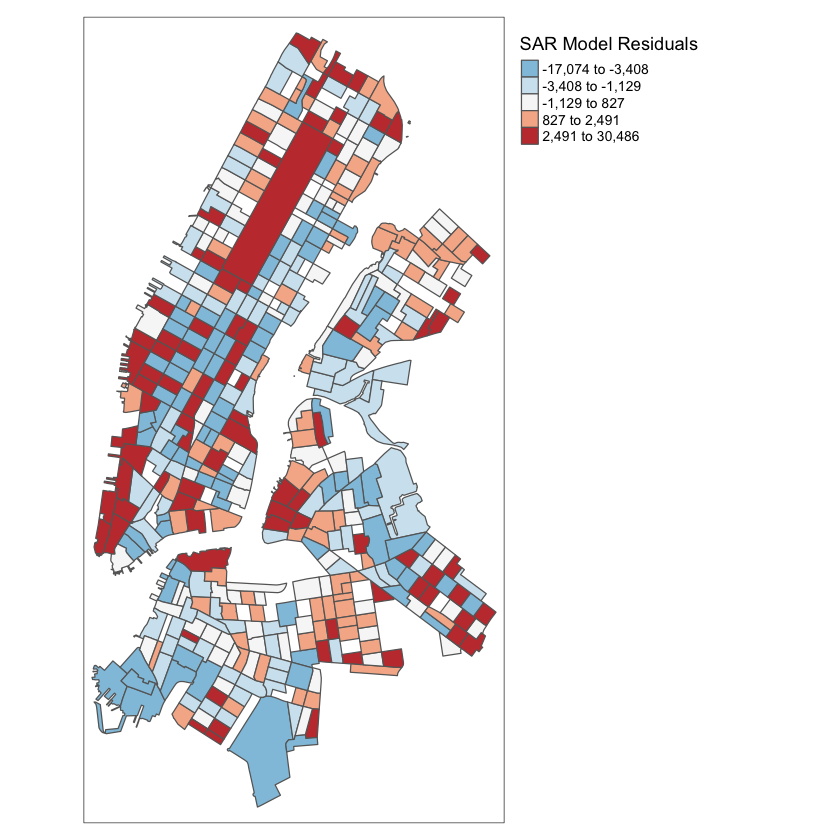

In [35]:
# 移除包含 NA 的行
agg_citibike_oct_clean <- na.omit(agg_citibike_oct)

W <- nb2mat(nb, style='W', zero.policy = TRUE)
colnames(W) <- rownames(W)

# Creating a weights list
Wl <- nb2listw(nb, zero.policy = TRUE)
NbrL <- dnearneigh(st_centroid(agg_citibike_oct_clean), 0, 1.6)
# Creating a list of neighbours not including self
D <- nb2listw(NbrL, style='B')


# 重新拟合模型
sar_model_weekday <- lagsarlm(weekday_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + 
                              avg_peak_ratio + num_stations + total_housing_units + 
                              Fam + AvgHHSz + GQClgHsg + male_ratio, 
                              data = agg_citibike_oct_clean, 
                              listw = D)

# 计算残差
agg_citibike_oct_clean$residuals <- residuals(sar_model_weekday)

# 绘图
library(tmap)
tm_shape(agg_citibike_oct_clean) + 
  tm_polygons("residuals", 
              palette = "-RdBu", 
              style = "quantile", 
              title = "SAR Model Residuals") +
  tm_layout(legend.outside = TRUE)



In [36]:
# 提取模型系数
coefficients <- coef(sar_model_weekday)

# 计算每个变量的贡献
for (var in names(coefficients)) {
  # 跳过截距项
  if (var != "(Intercept)") {
    agg_citibike_oct_clean[[paste0("residual_", var)]] <- 
      agg_citibike_oct_clean[[var]] * coefficients[var]
  }
}

# 计算总残差（实际值 - 预测值）
agg_citibike_oct_clean$residual_total <- residuals(sar_model_weekday)
library(tmap)

# 获取变量名称（排除截距项）
variable_names <- names(coefficients)[names(coefficients) != "(Intercept)"]

# 创建子图
plots <- lapply(variable_names, function(var) {
  tm_shape(agg_citibike_oct_clean) + 
    tm_polygons(paste0("residual_", var), 
                palette = "-RdBu", 
                style = "quantile", 
                title = var) +
    tm_layout(legend.outside = TRUE)
})

# 绘制总残差图
total_residual_plot <- tm_shape(agg_citibike_oct_clean) + 
  tm_polygons("residual_total", 
              palette = "-RdBu", 
              style = "quantile", 
              title = "Total Residuals") +
  tm_layout(legend.outside = TRUE)

# 合并所有图
tmap_arrange(c(plots, total_residual_plot), ncol = 2)


ERROR: [1m[33mError[39m in `structure()`:[22m
[1m[22m[33m![39m Assigned data `value` must be compatible with existing data.
[31m✖[39m Existing data has 429 rows.
[31m✖[39m Assigned data has 0 rows.
[36mℹ[39m Only vectors of size 1 are recycled.
[1mCaused by error in `vectbl_recycle_rhs_rows()`:[22m
[33m![39m Can't recycle input of size 0 to size 429.


In [37]:
head(agg_citibike_oct_clean)

BoroCT2020 total_ride_activity weekday_rides weekend_rides peak_rides
1 1000202    10690                7877         2813           4695     
2 1000600    21427               16544         4883           9477     
3 1000700    47624               39505         8119          25178     
4 1000800    10151                7359         2792           3984     
5 1000900    19862               15704         4158           9585     
6 1001002     4369                3185         1184           1872     
  weekday_peak_rides weekday_offpeak_rides weekend_peak_rides
1  3875               4002                  820              
2  8159               8385                 1318              
3 22833              16672                 2345              
4  3255               4104                  729              
5  8542               7162                 1043              
6  1566               1619                  306              
  weekend_offpeak_rides avg_weekday_ratio geometry                       ⋯
1 1993                  0.7400998         MULTIPOLYGON (((-73.98237 4... ⋯
2 3565                  0.7636773         MULTIPOLYGON (((-73.99022 4... ⋯
3 5774                  0.8309357         MULTIPOLYGON (((-73.998 40.... ⋯
4 2063                  0.7269471         MULTIPOLYGON (((-73.99191 4... ⋯
5 3115                  0.8005846         MULTIPOLYGON (((-74.00078 4... ⋯
6  878                  0.7289998         MULTIPOLYGON (((-73.97357 4... ⋯
  HUnits Fam   AvgHHSz GQClgHsg male_population female_population Pop19t64
1  7024   3706  4.18   0         89.4           110.6              8252   
2 17370   8070  7.02   0        137.4           162.6             20622   
3 49469  12299 12.32   0        338.8           361.2             64533   
4  9618   5262  4.60   0         96.8           103.2             13250   
5  4496   1720  8.16   0        225.6           174.4              6372   
6  2419   1508  2.43   0         42.6            57.4              3483   
  geometry                       male_ratio residuals 
1 MULTIPOLYGON (((-73.98237 4... 0.447        978.2801
2 MULTIPOLYGON (((-73.99022 4... 0.458       4040.1419
3 MULTIPOLYGON (((-73.998 40.... 0.484      -3726.7170
4 MULTIPOLYGON (((-73.99191 4... 0.484       1104.2782
5 MULTIPOLYGON (((-74.00078 4... 0.564       -519.4620
6 MULTIPOLYGON (((-73.97357 4... 0.426       -943.0813

In [33]:
# 构建 SAR 模型，以 weekend_rides 为因变量
sar_model_weekend <- lagsarlm(weekend_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
                              data = agg_citibike_oct, 
                              listw = D)

# 查看模型摘要
summary(sar_model_weekend)


Warning message in lagsarlm(weekend_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=3.23878e-17 - using numerical Hessian.”



Call:lagsarlm(formula = weekend_rides ~ PopU18 + Pop19t64 + Pop65pl + 
    avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + 
    Fam + AvgHHSz + GQClgHsg + male_ratio, data = agg_citibike_oct, 
    listw = D)

Residuals:
       Min         1Q     Median         3Q        Max 
-6143.2118  -676.9183    -5.1711   542.9988  7500.3066 

Type: lag 
Coefficients: (numerical Hessian approximate standard errors) 
                       Estimate  Std. Error z value  Pr(>|z|)
(Intercept)         -2.0976e+01  1.6612e+02 -0.1263 0.8995198
PopU18              -3.9599e-01  1.0479e-01 -3.7789 0.0001575
Pop19t64            -3.7488e-01  5.8639e-02 -6.3931 1.625e-10
Pop65pl             -1.6703e-01  8.1416e-02 -2.0516 0.0402069
avg_weekday_ratio   -3.3780e+03  8.0878e+02 -4.1766 2.959e-05
avg_peak_ratio       8.3053e+02  1.1019e+03  0.7538 0.4509977
num_stations         1.9266e+02  1.5954e+02  1.2076 0.2271823
total_housing_units  6.3039e-01  7.7817e-02  8.1009 4.441e-16
Fam     

In [35]:
# 构建 SEM 模型，以 weekend_rides 为因变量
sem_weekday_rides <- errorsarlm(weekday_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
                                data = agg_citibike_oct, 
                                listw = D)

# 查看模型摘要
summary(sem_weekday_rides)


Warning message in errorsarlm(weekday_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=2.90854e-19 - using numerical Hessian.”



Call:errorsarlm(formula = weekday_rides ~ PopU18 + Pop19t64 + Pop65pl + 
    avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + 
    Fam + AvgHHSz + GQClgHsg + male_ratio, data = agg_citibike_oct, 
    listw = D)

Residuals:
        Min          1Q      Median          3Q         Max 
-15818.3935  -2165.6834     -1.5871   1821.3124  32777.2548 

Type: error 
Coefficients: (asymptotic standard errors) 
                       Estimate  Std. Error z value  Pr(>|z|)
(Intercept)         -1.0758e+04  3.6643e+03 -2.9359  0.003326
PopU18               2.7079e-01  6.7900e-01  0.3988  0.690038
Pop19t64            -1.1974e+00  2.6918e-01 -4.4485 8.646e-06
Pop65pl             -6.0224e-01  4.4066e-01 -1.3667  0.171724
avg_weekday_ratio    7.4760e+02  4.1778e+03  0.1789  0.857980
avg_peak_ratio       9.9831e+03  4.2043e+03  2.3745  0.017572
num_stations         2.8784e+03  6.1447e+02  4.6844 2.807e-06
total_housing_units  2.1694e+00  3.2460e-01  6.6835 2.333e-11
Fam          

In [36]:
# 构建 SEM 模型，以 weekend_rides 为因变量
sem_model_weekend <- errorsarlm(weekend_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
                                data = agg_citibike_oct, 
                                listw = D)

# 查看模型摘要
summary(sem_model_weekend)


Warning message in errorsarlm(weekend_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=4.5137e-17 - using numerical Hessian.”



Call:errorsarlm(formula = weekend_rides ~ PopU18 + Pop19t64 + Pop65pl + 
    avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + 
    Fam + AvgHHSz + GQClgHsg + male_ratio, data = agg_citibike_oct, 
    listw = D)

Residuals:
      Min        1Q    Median        3Q       Max 
-5766.195  -677.345    55.589   509.217  6706.245 

Type: error 
Coefficients: (asymptotic standard errors) 
                       Estimate  Std. Error z value  Pr(>|z|)
(Intercept)          2.1115e+03  9.9428e+02  2.1236 0.0337016
PopU18              -4.8990e-01  1.8419e-01 -2.6598 0.0078194
Pop19t64            -3.4680e-01  7.3039e-02 -4.7482 2.053e-06
Pop65pl             -1.8559e-01  1.1953e-01 -1.5527 0.1205016
avg_weekday_ratio   -5.1465e+03  1.1336e+03 -4.5400 5.626e-06
avg_peak_ratio       1.0957e+03  1.1404e+03  0.9608 0.3366363
num_stations         7.4893e+01  1.6667e+02  0.4494 0.6531753
total_housing_units  5.9522e-01  8.8076e-02  6.7580 1.399e-11
Fam                  4.5342e-02  

In [38]:
# SAR 模型：weekday_peak_ride
sar_model_weekday_peak <- lagsarlm(weekday_peak_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
                                   data = agg_citibike_oct, 
                                   listw = D)

# 查看模型摘要
summary(sar_model_weekday_peak)


Warning message in lagsarlm(weekday_peak_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=2.22824e-18 - using numerical Hessian.”



Call:lagsarlm(formula = weekday_peak_rides ~ PopU18 + Pop19t64 + Pop65pl + 
    avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + 
    Fam + AvgHHSz + GQClgHsg + male_ratio, data = agg_citibike_oct, 
    listw = D)

Residuals:
      Min        1Q    Median        3Q       Max 
-7407.405 -1309.984   -45.741  1039.421 18306.284 

Type: lag 
Coefficients: (numerical Hessian approximate standard errors) 
                       Estimate  Std. Error z value  Pr(>|z|)
(Intercept)         -9516.05292  1793.46449 -5.3060 1.121e-07
PopU18                  0.66899     0.35317  1.8943 0.0581902
Pop19t64               -0.45009     0.12745 -3.5315 0.0004132
Pop65pl                -0.30819     0.22991 -1.3405 0.1800902
avg_weekday_ratio    2732.60681  2006.16635  1.3621 0.1731651
avg_peak_ratio       7222.89689  2211.18935  3.2665 0.0010888
num_stations         2060.20051   326.34055  6.3130 2.736e-10
total_housing_units     0.97345     0.15582  6.2474 4.173e-10
Fam          

In [40]:
# SEM 模型：weekday_peak_ride
sem_model_weekday_peak <- errorsarlm(weekday_peak_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
                                     data = agg_citibike_oct, 
                                     listw = D)

# 查看模型摘要
summary(sem_model_weekday_peak)


Warning message in errorsarlm(weekday_peak_rides ~ PopU18 + Pop19t64 + Pop65pl + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=4.47786e-18 - using numerical Hessian.”



Call:errorsarlm(formula = weekday_peak_rides ~ PopU18 + Pop19t64 + 
    Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + 
    total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
    data = agg_citibike_oct, listw = D)

Residuals:
      Min        1Q    Median        3Q       Max 
-6978.999 -1143.207   -62.465   879.457 18321.171 

Type: error 
Coefficients: (asymptotic standard errors) 
                       Estimate  Std. Error z value  Pr(>|z|)
(Intercept)         -7543.93533  1979.31014 -3.8114 0.0001382
PopU18                  0.43022     0.36696  1.1724 0.2410500
Pop19t64               -0.62289     0.14541 -4.2838 1.837e-05
Pop65pl                -0.42350     0.23817 -1.7781 0.0753803
avg_weekday_ratio    1354.90279  2256.70843  0.6004 0.5482471
avg_peak_ratio       8255.47231  2272.49191  3.6328 0.0002804
num_stations         1884.96788   332.14455  5.6751 1.386e-08
total_housing_units     1.13650     0.17534  6.4818 9.064e-11
Fam                    -0.65

In [41]:
# SAR 模型：weekday_offpeak_ride
sar_model_weekday_offpeak <- lagsarlm(weekday_offpeak_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
                                      data = agg_citibike_oct, 
                                      listw = D)

# 查看模型摘要
summary(sar_model_weekday_offpeak)


Warning message in lagsarlm(weekday_offpeak_rides ~ PopU18 + Pop19t64 + Pop65pl + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=2.94225e-18 - using numerical Hessian.”



Call:lagsarlm(formula = weekday_offpeak_rides ~ PopU18 + Pop19t64 + 
    Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + 
    total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
    data = agg_citibike_oct, listw = D)

Residuals:
     Min       1Q   Median       3Q      Max 
-9376.34 -1239.48    41.21  1083.59 15261.33 

Type: lag 
Coefficients: (numerical Hessian approximate standard errors) 
                       Estimate  Std. Error z value  Pr(>|z|)
(Intercept)         -5.7668e+03  1.6025e+03 -3.5986 0.0003199
PopU18               3.3569e-02  2.4422e-01  0.1375 0.8906733
Pop19t64            -5.1583e-01  1.1284e-01 -4.5713 4.848e-06
Pop65pl             -1.3143e-01  1.9457e-01 -0.6755 0.4993805
avg_weekday_ratio    1.2337e+03  1.8084e+03  0.6822 0.4951009
avg_peak_ratio       1.3835e+03  1.9907e+03  0.6950 0.4870533
num_stations         1.1884e+03  2.9043e+02  4.0918 4.281e-05
total_housing_units  9.8441e-01  1.3987e-01  7.0381 1.948e-12
Fam                 

In [43]:
# SEM 模型：weekday_offpeak_ride
sem_model_weekday_offpeak <- errorsarlm(weekday_offpeak_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
                                        data = agg_citibike_oct, 
                                        listw = D)

# 查看模型摘要
summary(sem_model_weekday_offpeak)


Warning message in errorsarlm(weekday_offpeak_rides ~ PopU18 + Pop19t64 + Pop65pl + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=4.40338e-18 - using numerical Hessian.”



Call:errorsarlm(formula = weekday_offpeak_rides ~ PopU18 + Pop19t64 + 
    Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + 
    total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
    data = agg_citibike_oct, listw = D)

Residuals:
     Min       1Q   Median       3Q      Max 
-8840.53 -1066.12    98.62   943.81 15910.68 

Type: error 
Coefficients: (asymptotic standard errors) 
                       Estimate  Std. Error z value  Pr(>|z|)
(Intercept)         -3229.09547  1774.32233 -1.8199 0.0687737
PopU18                 -0.15814     0.32869 -0.4811 0.6304257
Pop19t64               -0.57422     0.13034 -4.4055 1.055e-05
Pop65pl                -0.17830     0.21330 -0.8359 0.4032171
avg_weekday_ratio    -592.17884  2022.95720 -0.2927 0.7697291
avg_peak_ratio       1731.26558  2035.01972  0.8507 0.3949157
num_stations          995.00839   297.41848  3.3455 0.0008214
total_housing_units     1.03293     0.15717  6.5719 4.968e-11
Fam                    -0.52749    

In [45]:
# SAR 模型：weekend_peak_ride
sar_model_weekend_peak <- lagsarlm(weekend_peak_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
                                   data = agg_citibike_oct, 
                                   listw = D)

# 查看模型摘要
summary(sar_model_weekend_peak)



Call:lagsarlm(formula = weekend_peak_rides ~ PopU18 + Pop19t64 + Pop65pl + 
    avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + 
    Fam + AvgHHSz + GQClgHsg + male_ratio, data = agg_citibike_oct, 
    listw = D)

Residuals:
       Min         1Q     Median         3Q        Max 
-1580.8775  -187.1786    -2.1704   147.8301  1701.6660 

Type: lag 
Coefficients: (asymptotic standard errors) 
                       Estimate  Std. Error z value  Pr(>|z|)
(Intercept)         -159.118854  239.623774 -0.6640  0.506667
PopU18                -0.082734    0.048009 -1.7233  0.084836
Pop19t64              -0.097471    0.017561 -5.5504 2.850e-08
Pop65pl               -0.034143    0.031436 -1.0861  0.277431
avg_weekday_ratio   -817.784123  268.778012 -3.0426  0.002345
avg_peak_ratio       322.548805  305.442364  1.0560  0.290966
num_stations          75.868522   44.776815  1.6944  0.090195
total_housing_units    0.170721    0.021520  7.9332 2.220e-15
Fam                   

In [47]:
# SEM 模型：weekend_peak_ride
sem_model_weekend_peak <- errorsarlm(weekend_peak_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
                                     data = agg_citibike_oct, 
                                     listw = D)

# 查看模型摘要
summary(sem_model_weekend_peak)



Call:errorsarlm(formula = weekend_peak_rides ~ PopU18 + Pop19t64 + 
    Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + 
    total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
    data = agg_citibike_oct, listw = D)

Residuals:
      Min        1Q    Median        3Q       Max 
-1482.444  -194.843    11.633   138.789  1717.228 

Type: error 
Coefficients: (asymptotic standard errors) 
                       Estimate  Std. Error z value  Pr(>|z|)
(Intercept)          3.2929e+02  2.6750e+02  1.2310 0.2183356
PopU18              -1.1018e-01  4.9556e-02 -2.2233 0.0261963
Pop19t64            -9.5605e-02  1.9651e-02 -4.8652 1.143e-06
Pop65pl             -3.9072e-02  3.2159e-02 -1.2150 0.2243802
avg_weekday_ratio   -1.1892e+03  3.0499e+02 -3.8991 9.654e-05
avg_peak_ratio       4.0891e+02  3.0682e+02  1.3327 0.1826152
num_stations         4.6050e+01  4.4841e+01  1.0270 0.3044387
total_housing_units  1.6789e-01  2.3696e-02  7.0851 1.389e-12
Fam                 -1.4246e

In [49]:
# SAR 模型：weekend_offpeak_ride
sar_model_weekend_offpeak <- lagsarlm(weekend_offpeak_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
                                      data = agg_citibike_oct, 
                                      listw = D)

# 查看模型摘要
summary(sar_model_weekend_offpeak)


Warning message in lagsarlm(weekend_offpeak_rides ~ PopU18 + Pop19t64 + Pop65pl + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=1.11486e-16 - using numerical Hessian.”



Call:lagsarlm(formula = weekend_offpeak_rides ~ PopU18 + Pop19t64 + 
    Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + 
    total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
    data = agg_citibike_oct, listw = D)

Residuals:
       Min         1Q     Median         3Q        Max 
-4562.5636  -503.4587    -2.3667   409.3518  5800.2238 

Type: lag 
Coefficients: (numerical Hessian approximate standard errors) 
                       Estimate  Std. Error z value  Pr(>|z|)
(Intercept)          1.3455e+02  5.6935e+02  0.2363  0.813189
PopU18              -3.1292e-01  7.5371e-02 -4.1517 3.300e-05
Pop19t64            -2.7745e-01  4.4173e-02 -6.2811 3.363e-10
Pop65pl             -1.3239e-01  6.1442e-02 -2.1548  0.031180
avg_weekday_ratio   -2.5571e+03  7.9172e+02 -3.2297  0.001239
avg_peak_ratio       5.1150e+02  7.9792e+02  0.6410  0.521492
num_stations         1.1724e+02  1.1901e+02  0.9851  0.324560
total_housing_units  4.5998e-01  5.8392e-02  7.8774 3.331e-15


In [50]:
# SEM 模型：weekend_offpeak_ride
sem_model_weekend_offpeak <- errorsarlm(weekend_offpeak_rides ~ PopU18 + Pop19t64 + Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
                                        data = agg_citibike_oct, 
                                        listw = D)

# 查看模型摘要
summary(sem_model_weekend_offpeak)


Warning message in errorsarlm(weekend_offpeak_rides ~ PopU18 + Pop19t64 + Pop65pl + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=1.56819e-16 - using numerical Hessian.”



Call:errorsarlm(formula = weekend_offpeak_rides ~ PopU18 + Pop19t64 + 
    Pop65pl + avg_weekday_ratio + avg_peak_ratio + num_stations + 
    total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
    data = agg_citibike_oct, listw = D)

Residuals:
      Min        1Q    Median        3Q       Max 
-4283.916  -480.481    32.612   366.430  5176.947 

Type: error 
Coefficients: (asymptotic standard errors) 
                       Estimate  Std. Error z value  Pr(>|z|)
(Intercept)          1.7813e+03  7.3263e+02  2.4314 0.0150416
PopU18              -3.7967e-01  1.3572e-01 -2.7974 0.0051523
Pop19t64            -2.5126e-01  5.3818e-02 -4.6687 3.031e-06
Pop65pl             -1.4651e-01  8.8078e-02 -1.6634 0.0962337
avg_weekday_ratio   -3.9564e+03  8.3529e+02 -4.7365 2.174e-06
avg_peak_ratio       6.8723e+02  8.4033e+02  0.8178 0.4134633
num_stations         2.8898e+01  1.2281e+02  0.2353 0.8139795
total_housing_units  4.2742e-01  6.4898e-02  6.5860 4.518e-11
Fam                  4.67

In [36]:
# 计算 peak_ride_ratio 和 weekday_ride_ratio
agg_citibike_oct$peak_ride_ratio <- (agg_citibike_oct$weekday_peak_rides + agg_citibike_oct$weekend_peak_rides) / agg_citibike_oct$total_ride_activity
agg_citibike_oct$weekday_ride_ratio <- agg_citibike_oct$weekday_rides / agg_citibike_oct$total_ride_activity


In [53]:
# SAR 模型：total_ride 作为因变量
sar_model_total <- lagsarlm(total_ride_activity ~ peak_ride_ratio + weekday_ride_ratio + PopU18 + Pop19t64 + Pop65pl + num_stations + total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
                            data = agg_citibike_oct, 
                            listw = D)

# 查看模型摘要
summary(sar_model_total)


Warning message in lagsarlm(total_ride_activity ~ peak_ride_ratio + weekday_ride_ratio + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=7.42468e-20 - using numerical Hessian.”



Call:
lagsarlm(formula = total_ride_activity ~ peak_ride_ratio + weekday_ride_ratio + 
    PopU18 + Pop19t64 + Pop65pl + num_stations + total_housing_units + 
    Fam + AvgHHSz + GQClgHsg + male_ratio, data = agg_citibike_oct, 
    listw = D)

Residuals:
       Min         1Q     Median         3Q        Max 
-22929.231  -3230.759     38.262   2818.072  33587.508 

Type: lag 
Coefficients: (numerical Hessian approximate standard errors) 
                       Estimate  Std. Error z value  Pr(>|z|)
(Intercept)         -1.6914e+04  4.0970e+03 -4.1284 3.653e-05
peak_ride_ratio      7.1154e+03  5.2194e+03  1.3633 0.1728026
weekday_ride_ratio   4.1843e+03  4.6645e+03  0.8970 0.3696936
PopU18               2.8170e-01  8.3969e-01  0.3355 0.7372606
Pop19t64            -1.3243e+00  2.9393e-01 -4.5056 6.619e-06
Pop65pl             -6.0853e-01  5.4162e-01 -1.1235 0.2612070
num_stations         3.5015e+03  7.5926e+02  4.6117 3.993e-06
total_housing_units  2.5594e+00  3.5675e-01  7.1742 7.270e-13

In [55]:
# SEM 模型：total_ride 作为因变量
sem_model_total <- errorsarlm(total_ride_activity ~ peak_ride_ratio + weekday_ride_ratio + PopU18 + Pop19t64 + Pop65pl + num_stations + total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
                              data = agg_citibike_oct, 
                              listw = D)

# 查看模型摘要
summary(sem_model_total)


Warning message in errorsarlm(total_ride_activity ~ peak_ride_ratio + weekday_ride_ratio + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=1.24151e-19 - using numerical Hessian.”



Call:errorsarlm(formula = total_ride_activity ~ peak_ride_ratio + 
    weekday_ride_ratio + PopU18 + Pop19t64 + Pop65pl + num_stations + 
    total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
    data = agg_citibike_oct, listw = D)

Residuals:
       Min         1Q     Median         3Q        Max 
-21621.366  -2890.006     85.484   2295.513  35537.216 

Type: error 
Coefficients: (asymptotic standard errors) 
                       Estimate  Std. Error z value  Pr(>|z|)
(Intercept)         -1.0666e+04  4.5327e+03 -2.3532 0.0186142
peak_ride_ratio      8.6240e+03  5.2922e+03  1.6296 0.1031953
weekday_ride_ratio  -2.6295e+02  5.3496e+03 -0.0492 0.9607981
PopU18              -2.3823e-01  8.3506e-01 -0.2853 0.7754279
Pop19t64            -1.5301e+00  3.3146e-01 -4.6163 3.906e-06
Pop65pl             -7.8305e-01  5.4240e-01 -1.4437 0.1488327
num_stations         3.0016e+03  7.5746e+02  3.9627 7.410e-05
total_housing_units  2.7458e+00  3.9949e-01  6.8735 6.267e-12
Fam            

In [51]:
# 读取 CT2020.csv 文件
ct2020_jan <- read.csv("BoroCT2020_01.csv", colClasses = c("CT2020" = "character"))
ct2020_jan_vector <- ct2020_jan$CT2020

In [52]:
ct2020_oct_vector <- agg_citibike_oct$BoroCT2020

In [53]:
# 找出 1 月有而 10 月没有的值
jan_not_in_oct <- setdiff(ct2020_jan_vector, ct2020_oct_vector)

# 找出 10 月有而 1 月没有的值
oct_not_in_jan <- setdiff(ct2020_oct_vector, ct2020_jan_vector)

# 打印结果并计数
cat("1 月有而 10 月没有的值 (共", length(jan_not_in_oct), "个)：", jan_not_in_oct, "\n")
cat("10 月有而 1 月没有的值 (共", length(oct_not_in_jan), "个)：", oct_not_in_jan, "\n")


1 月有而 10 月没有的值 (共 20 个)： 1011402 1016500 2022703 2023301 2024300 2036901 2037504 2038700 2036100 2038900 2039700 2039300 2039901 4000101 1004700 2038500 2037900 2038100 2023501 2023502 
10 月有而 1 月没有的值 (共 39 个)： 1000500 1006800 1010802 1015801 1021900 3037300 3038900 3039100 3039300 3039500 3039700 3039900 3040100 3040300 3040900 3041100 3041300 3041500 3041900 3042100 3042300 3042500 3042700 3042900 3043100 3043300 3043500 3043700 3043900 3044100 3044300 3044500 3044700 3044901 3044902 3045300 3048100 3048500 3057902 


In [54]:
# 打印 1 月和 10 月的 CT2020 总数量
cat("1 月的 CT2020 总数量：", length(ct2020_jan_vector), "\n")
cat("10 月的 CT2020 总数量：", length(ct2020_oct_vector), "\n")

1 月的 CT2020 总数量： 416 
10 月的 CT2020 总数量： 435 


In [63]:
# 提取 CT2020 列并保存为数据框
ct2020_df <- data.frame(CT2020 = agg_citibike_oct$BoroCT2020)

# 保存为 CSV 文件
write.csv(ct2020_df, "CT2020_2019_10.csv", row.names = FALSE)

In [64]:
head(agg_citibike_oct)

BoroCT2020 total_ride_activity weekday_rides weekend_rides peak_rides
1 1000202    10690                7877         2813           4695     
2 1000500     5174                1608         3566            572     
3 1000600    21427               16544         4883           9477     
4 1000700    47624               39505         8119          25178     
5 1000800    10151                7359         2792           3984     
6 1000900    19862               15704         4158           9585     
  weekday_peak_rides weekday_offpeak_rides weekend_peak_rides
1  3875               4002                  820              
2   150               1458                  422              
3  8159               8385                 1318              
4 22833              16672                 2345              
5  3255               4104                  729              
6  8542               7162                 1043              
  weekend_offpeak_rides avg_weekday_ratio geometry                       ⋯
1 1993                  0.7400998         MULTIPOLYGON (((-73.98237 4... ⋯
2 3144                  0.3085826         MULTIPOLYGON (((-74.01093 4... ⋯
3 3565                  0.7636773         MULTIPOLYGON (((-73.99022 4... ⋯
4 5774                  0.8309357         MULTIPOLYGON (((-73.998 40.... ⋯
5 2063                  0.7269471         MULTIPOLYGON (((-73.99191 4... ⋯
6 3115                  0.8005846         MULTIPOLYGON (((-74.00078 4... ⋯
  Fam   AvgHHSz GQClgHsg male_population female_population Pop19t64
1  3706  4.18   0         89.4           110.6              8252   
2     0  0.00   0         60.0           240.0                12   
3  8070  7.02   0        137.4           162.6             20622   
4 12299 12.32   0        338.8           361.2             64533   
5  5262  4.60   0         96.8           103.2             13250   
6  1720  8.16   0        225.6           174.4              6372   
  geometry                       peak_ride_ratio weekday_ride_ratio male_ratio
1 MULTIPOLYGON (((-73.98237 4... 0.4391955       0.7368569          0.447     
2 MULTIPOLYGON (((-74.01093 4... 0.1105528       0.3107847          0.200     
3 MULTIPOLYGON (((-73.99022 4... 0.4422924       0.7721100          0.458     
4 MULTIPOLYGON (((-73.998 40.... 0.5286830       0.8295187          0.484     
5 MULTIPOLYGON (((-73.99191 4... 0.3924736       0.7249532          0.484     
6 MULTIPOLYGON (((-74.00078 4... 0.4825798       0.7906555          0.564

In [65]:
# 找到 1 月和 10 月的交集
common_values <- intersect(ct2020_jan_vector, ct2020_oct_vector)

# 筛选 agg_citibike_oct 中 CT2020 列属于交集的行
agg_citibike_oct_filtered <- agg_citibike_oct[agg_citibike_oct$BoroCT2020 %in% common_values, ]

# 查看结果
cat("筛选前行数：", nrow(agg_citibike_oct), "\n")
cat("筛选后行数：", nrow(agg_citibike_oct_filtered), "\n")



筛选前行数： 435 
筛选后行数： 396 


In [66]:
library(spdep)
library(knitr)
nb <- poly2nb(agg_citibike_oct_filtered)
W <- nb2mat(nb, style='W', zero.policy = TRUE)
colnames(W) <- rownames(W)
NbrL <- dnearneigh(st_centroid(agg_citibike_oct_filtered), 0, 1.6)
# Creating a weights list
Wl <- nb2listw(nb, zero.policy = TRUE)
moran(agg_citibike_oct_filtered$total_ride_activity, Wl, n=length(Wl$neighbours), S0=Szero(Wl))

# Creating a list of neighbours not including self
D <- nb2listw(NbrL, style='B')
# Creating a list of neighbours, but include self
D_star <- nb2listw(include.self(NbrL), style='B')

G <- globalG.test(agg_citibike_oct_filtered$total_ride_activity, D)
G <- globalG.test(agg_citibike_oct_filtered$total_ride_activity, D_star)

# Check if there are any isolated observations (no neighbors) by returning the length (number of neighbours) for each polygon
sapply(NbrL, length)

Warning message in poly2nb(agg_citibike_oct_filtered):
“some observations have no neighbours;
if this seems unexpected, try increasing the snap argument.”
Warning message in poly2nb(agg_citibike_oct_filtered):
“neighbour object has 3 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.”
Warning message:
“st_centroid assumes attributes are constant over geometries”


$I
[1] 0.4515937

$K
[1] 16.2836

[1] 27 29 16 28 14 27 31 14 30 23 20 34 38 29 20 33 34 31 28 32 30 32 30 39 40
 [26] 28 39 27 37 44 47 25 41 22 41 45 38 44 43 33 40 41 35 42 42 41 41 46 43 43
 [51] 44 44 31 46 26 39 39 37 32 31 20 30 36 33 32 40 43 31 31 24 34 37 41 28 42
 [76] 27 38 30 28 33 39 35 29 39 42 40 33 30 22 24 24 31 40 37 32 38 27 29 31 41
[101] 26 33 39 36 30 43 34 33 24 27 43 27 35 33 32 28 41 30 33 29 25 31 39 32 28
[126] 24 29 28 37 25 31 26 31 30 30 30 28 29 28 24 27 25 29 21 19 23 29 27 28 17
[151] 27 29 23 17 32 22 27 18 25 27 18 30 20 26 16 28 20 31 16 20 20 16 26 20 28
[176] 14 32 34 18 24 25 31 18 17 26 20 18 23 25 27 19 23 28 18 21 22 22 14 17 19
[201] 34 33 26 22 18 25 15 12 26 26 26 28 26 33 34 30 32 38  1 27 25 33 40 37 41
[226] 40 40 43 45 38 30 24 22  6 10 14 21 25 27 37 36 44 36 29 13 18 36 26 45 44
[251] 40 40 35 29 22 17 14 15 15 22 26 31 37 36 37 12 37 38 35 31 30 36 40 39 35
[276] 36 34 32 25 16 21 18 25 31 35 36 31 31 32 30 33 30 28 29 30 27 28 29 28 23
[301] 13 15 19 24 26 28 25 20 10 27 10 13  8 19 22 23 23 24 22 25 28 25 26 28 29
[326] 28 26 25 26 25 25 29 30 24 20 23 24 28 27 27 19 14 16 16 21 15 16 18 31 19
[351] 19 15 16 16 17 19 19 22 21 22 21 25 25 24 25 27 25 21 23 25 28 27 23 28 30
[376] 28 25 23 21 28 20 20 18 16 15 16 16 13 20 18 20 15 20 14 11 10

In [67]:
# 检查数据集行数
nrow(agg_citibike_oct)

# 检查空间权重矩阵的行数
length(D$neighbours)


[1] 435

[1] 396

In [77]:
filtered_sar_model_total <- lagsarlm(total_ride_activity ~ peak_ride_ratio + weekday_ride_ratio + PopU18 + Pop19t64 + Pop65pl + num_stations + total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
                            data = agg_citibike_oct_filtered, 
                            listw = D)

# 查看模型摘要
summary(filtered_sar_model_total)

Warning message in lagsarlm(total_ride_activity ~ peak_ride_ratio + weekday_ride_ratio + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=7.04024e-20 - using numerical Hessian.”
Warning message in sqrt(diag(fdHess)[-1]):
“产生了NaNs”



Call:
lagsarlm(formula = total_ride_activity ~ peak_ride_ratio + weekday_ride_ratio + 
    PopU18 + Pop19t64 + Pop65pl + num_stations + total_housing_units + 
    Fam + AvgHHSz + GQClgHsg + male_ratio, data = agg_citibike_oct_filtered, 
    listw = D)

Residuals:
       Min         1Q     Median         3Q        Max 
-14290.431  -3162.601    -75.039   2676.723  32688.430 

Type: lag 
Coefficients: (numerical Hessian approximate standard errors) 
                       Estimate  Std. Error z value  Pr(>|z|)
(Intercept)         -1.8854e+04  3.4366e+03 -5.4862 4.107e-08
peak_ride_ratio      1.6248e+04  6.2772e+03  2.5884 0.0096424
weekday_ride_ratio   6.4138e+02         NaN     NaN       NaN
PopU18               5.3219e-01  8.6394e-01  0.6160 0.5378935
Pop19t64            -8.0742e-01  3.1496e-01 -2.5636 0.0103596
Pop65pl             -8.6330e-02  5.4802e-01 -0.1575 0.8748260
num_stations         3.5438e+03  7.9829e+02  4.4392 9.029e-06
total_housing_units  2.0450e+00  3.6919e-01  5.5390 

In [88]:
# 将残差添加到数据集
agg_citibike_oct_filtered$lag.res <- residuals(filtered_sar_model_total)

# 绘制地图
tm_shape(agg_citibike_oct_filtered) +
  tm_polygons('lag.res', palette = '-RdBu', style = 'quantile')


ERROR: Error in `$<-.data.frame`(`*tmp*`, lag.res, value = c(`1` = 1286.2539215347, : 替换数据里有394行，但数据有0


In [83]:
nrow(agg_citibike_oct_filtered)  # 原始数据行数
nrow(used_data)                  # 模型中实际使用的数据行数


[1] 396

[1] 394

In [70]:
colnames(agg_citibike_oct_filtered)

[1] "BoroCT2020"                "total_ride_activity"      
 [3] "weekday_rides"             "weekend_rides"            
 [5] "peak_rides"                "weekday_peak_rides"       
 [7] "weekday_offpeak_rides"     "weekend_peak_rides"       
 [9] "weekend_offpeak_rides"     "avg_weekday_ratio"        
[11] "avg_peak_ratio"            "avg_weekday_peak_ratio"   
[13] "avg_weekday_offpeak_ratio" "avg_weekend_peak_ratio"   
[15] "avg_weekend_offpeak_ratio" "num_stations"             
[17] "total_housing_units"       "avg_household_size"       
[19] "Pop1"                      "PopU18"                   
[21] "Pop65pl"                   "PopU5"                    
[23] "Pop5t9"                    "Pop10t14"                 
[25] "Pop15t19"                  "Pop20t24"                 
[27] "Pop25t29"                  "Pop30t34"                 
[29] "Pop35t39"                  "Pop40t44"                 
[31] "Pop45t49"                  "Pop50t54"                 
[33] "Pop55t59"                  "Pop60t64"                 
[35] "Pop65t69"                  "Pop70t74"                 
[37] "Pop75t79"                  "Pop80t84"                 
[39] "Pop85pl"                   "HUnits"                   
[41] "Fam"                       "AvgHHSz"                  
[43] "GQClgHsg"                  "male_population"          
[45] "female_population"         "Pop19t64"                 
[47] "geometry"                  "peak_ride_ratio"          
[49] "weekday_ride_ratio"        "male_ratio"

In [81]:
formula(filtered_sar_model_total)

total_ride_activity ~ peak_ride_ratio + weekday_ride_ratio + 
    PopU18 + Pop19t64 + Pop65pl + num_stations + total_housing_units + 
    Fam + AvgHHSz + GQClgHsg + male_ratio
<environment: 0x3390e4ba8>

In [79]:
head(agg_citibike_oct_filtered$total_ride_activity)

[1] 10690 21427 47624 10151 19862  4369

In [75]:
# 查看模型使用的数据
used_data <- model.frame(filtered_sar_model_total)
#colnames(used_data)  # 检查数据集中是否包含 total_ride_activity


ERROR: Error in eval(predvars, data, env): 找不到对象'total_ride_activity'


In [72]:
"total_ride_activity" %in% colnames(agg_citibike_oct_filtered)


[1] TRUE

In [73]:
filtered_sem_model_total <- errorsarlm(total_ride_activity ~ peak_ride_ratio + weekday_ride_ratio + PopU18 + Pop19t64 + Pop65pl + num_stations + total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
                            data = agg_citibike_oct_filtered, 
                            listw = D)

# 查看模型摘要
summary(filtered_sem_model_total)

Warning message in errorsarlm(total_ride_activity ~ peak_ride_ratio + weekday_ride_ratio + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=1.25906e-19 - using numerical Hessian.”



Call:errorsarlm(formula = total_ride_activity ~ peak_ride_ratio + 
    weekday_ride_ratio + PopU18 + Pop19t64 + Pop65pl + num_stations + 
    total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
    data = agg_citibike_oct_filtered, listw = D)

Residuals:
       Min         1Q     Median         3Q        Max 
-15819.306  -2775.747     57.128   2475.806  34475.021 

Type: error 
Coefficients: (asymptotic standard errors) 
                       Estimate  Std. Error z value  Pr(>|z|)
(Intercept)         -1.4706e+04  5.9160e+03 -2.4857 0.0129290
peak_ride_ratio      2.0340e+04  8.4725e+03  2.4007 0.0163653
weekday_ride_ratio  -2.9984e+03  7.7063e+03 -0.3891 0.6972117
PopU18              -1.4506e-01  8.5465e-01 -0.1697 0.8652223
Pop19t64            -1.0538e+00  3.5067e-01 -3.0052 0.0026538
Pop65pl             -3.4689e-01  5.5488e-01 -0.6252 0.5318668
num_stations         3.1117e+03  8.0375e+02  3.8715 0.0001082
total_housing_units  2.2047e+00  4.1866e-01  5.2660 1.395e-07
Fam   

In [ ]:
errorsarlm(formula = total_ride_activity ~ peak_ride_ratio + 
    weekday_ride_ratio + PopU18 + Pop19t64 + Pop65pl + num_stations + 
    total_housing_units + Fam + AvgHHSz + GQClgHsg + male_ratio, 
    data = agg_citibike_oct, listw = D)

In [89]:
summary(octbike.lag)


Call:lagsarlm(formula = total_ride_start_count ~ PopU18 + Pop19t64 + 
    Pop65pl + HUnits + Fam + AvgHHSz + GQClgHsg + Shape_Area + 
    num_stations, data = agg_citibike_oct_filtered, listw = D)

Residuals:
       Min         1Q     Median         3Q        Max 
-8224.8856 -1542.6994     2.7903  1589.7871 16468.3352 

Type: lag 
Coefficients: (numerical Hessian approximate standard errors) 
                Estimate  Std. Error z value  Pr(>|z|)
(Intercept)  -6.8376e+03  1.0618e+03 -6.4399 1.196e-10
PopU18       -2.6587e-01  6.8491e-01 -0.3882  0.697886
Pop19t64     -9.4531e-01  3.6753e-01 -2.5720  0.010110
Pop65pl      -1.8032e+00  6.4907e-01 -2.7781  0.005468
HUnits        1.7777e+00  4.5615e-01  3.8971 9.735e-05
Fam           7.1741e-01  1.2194e+00  0.5883  0.556320
AvgHHSz       8.0496e+02  4.6249e+02  1.7405  0.081775
GQClgHsg      1.6547e+00  6.3932e-01  2.5882  0.009648
Shape_Area    1.6553e-04  8.0697e-05  2.0513  0.040236
num_stations  2.8947e+03  1.6090e+02 17.9904 < 2.2e-1

In [92]:
octbike.err <- errorsarlm(total_ride_start_count ~ PopU18 + Pop19t64 + Pop65pl + HUnits + Fam + AvgHHSz + GQClgHsg + Shape_Area + num_stations, data=agg_citibike_oct_filtered, listw=D)

Warning message in errorsarlm(total_ride_start_count ~ PopU18 + Pop19t64 + Pop65pl + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=7.975e-21 - using numerical Hessian.”


In [93]:
summary(octbike.err)


Call:errorsarlm(formula = total_ride_start_count ~ PopU18 + Pop19t64 + 
    Pop65pl + HUnits + Fam + AvgHHSz + GQClgHsg + Shape_Area + 
    num_stations, data = agg_citibike_oct_filtered, listw = D)

Residuals:
     Min       1Q   Median       3Q      Max 
-8850.91 -1424.55   244.45  1468.90 16311.76 

Type: error 
Coefficients: (asymptotic standard errors) 
                Estimate  Std. Error z value  Pr(>|z|)
(Intercept)  -5.8846e+03  1.1472e+03 -5.1296 2.904e-07
PopU18       -7.4738e-01  7.7326e-01 -0.9665  0.333777
Pop19t64     -1.0467e+00  4.4995e-01 -2.3262  0.020008
Pop65pl      -2.1177e+00  7.0674e-01 -2.9964  0.002732
HUnits        1.6235e+00  5.6073e-01  2.8953  0.003788
Fam           1.9930e+00  1.3707e+00  1.4540  0.145936
AvgHHSz       9.3482e+02  4.7957e+02  1.9493  0.051259
GQClgHsg      1.6886e+00  6.5894e-01  2.5626  0.010390
Shape_Area    1.5552e-04  8.0234e-05  1.9383  0.052590
num_stations  2.8929e+03  1.5895e+02 18.2005 < 2.2e-16

Lambda: 0.027156, LR test value:

In [94]:
summary(octbike.lm)


Call:
lm(formula = total_ride_start_count ~ PopU18 + Pop19t64 + Pop65pl + 
    HUnits + Fam + AvgHHSz + GQClgHsg + Shape_Area + num_stations, 
    data = agg_citibike_oct)

Residuals:
     Min       1Q   Median       3Q      Max 
-15110.9  -2085.3   -316.7   1351.2  22851.2 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.053e+01  1.257e+03   0.024  0.98063    
PopU18        2.177e+00  9.805e-01   2.220  0.02693 *  
Pop19t64     -1.452e+00  4.875e-01  -2.979  0.00306 ** 
Pop65pl       8.745e-04  8.960e-01   0.001  0.99922    
HUnits        4.358e+00  5.870e-01   7.424 6.28e-13 ***
Fam          -7.351e+00  1.670e+00  -4.402 1.36e-05 ***
AvgHHSz      -7.399e+02  5.672e+02  -1.304  0.19278    
GQClgHsg      3.545e+00  8.619e-01   4.113 4.70e-05 ***
Shape_Area    4.292e-06  1.006e-04   0.043  0.96599    
num_stations  2.889e+03  2.048e+02  14.104  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: